In [2]:
import os

# 我們將使用layers API，選擇layers，並了解我們想要使用哪些，以及我們想要重新training哪些layers。
from tensorflow.keras import layers
from tensorflow.keras import Model
# 初始pre-trained神經網絡的訓練權重保存在此URL處
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

#
# 然後可以將參數加載到模型的骨架中，然後將其轉換為訓練模型。所以現在如果我們想要使用初始化
# 因此，您希望知道要為數據輸入數據，並且不想使用內置權重
# 初始V3在頂部具有完全連接的層。因此，通過將include_top設置為false，您指定要忽略它並直接進入卷積。
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)


# 現在建立我的預訓練模型
# 我可以"for layer in pre_trained_model.layers:"迭代它的圖層並鎖定它們，
# 不會重新訓練(改變否定"layer.trainable = False")。
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# 印出整個model 
pre_trained_model.summary()


#要使用的最後一個layer的名稱，將看到底層已經卷積為3乘3。
#但想用更多時所以我轉向模型描述找到mixed7，轉成7乘7的多重卷積的輸出。(視情況所需調整，可不必使用此方法)
#但是使用這段代碼，我將抓住那一層開始並將其輸出。所以我們將定義我們的新模型，我們稱之為last_ouput。
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2019-05-25 22:30:01--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2019-05-25 22:30:02 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None

In [7]:
#所以我們將定義我們的新模型
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
# 我們稱之為last_ouput，但這只是使用API層的另一種方式。
# "taking the output from the inception model's mixed7 layer"
# "You start by flattening the input,which just happens to be the output from inception."
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
# And then add a hidden layer.叫"Dense"
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
# 本周講述的重點工具，在這裡我們dropout 20%的權重
x = layers.Dropout(0.2)(x)   

# Add a final sigmoid layer for classification
# 然後你的輸出由sigmoid激活的神經元的layer在兩個項目之間進行分類。
x = layers.Dense  (1, activation='sigmoid')(x)           

# 創建模型，並傳遞您剛剛創建的輸入和圖層定義。
model = Model( pre_trained_model.input, x) 
# 然後使用優化器和損失函數以及要收集的度量標準對其進行編譯
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

#再者使用上次的"ImageDataGenerator"如下所示


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
# #圖像生成器來增加圖像，然後，和以前一樣，我們可以通過從指定目錄流出並經歷所有增加來從生成器獲取我們的訓練數據。
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2019-05-25 23:09:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   113MB/s    in 0.6s    

2019-05-25 23:09:31 (113 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
# now we can train as before with model.fit_generator.and going to run it for 100 epochs
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
50/50 [==============================] - 5s 104ms/step - loss: 0.2276 - acc: 0.9310
 - 20s - loss: 0.5093 - acc: 0.7580 - val_loss: 0.2276 - val_acc: 0.9310
Epoch 2/20
50/50 [==============================] - 5s 94ms/step - loss: 0.1835 - acc: 0.9520
 - 19s - loss: 0.3760 - acc: 0.8355 - val_loss: 0.1835 - val_acc: 0.9520
Epoch 3/20
50/50 [==============================] - 5s 94ms/step - loss: 0.2530 - acc: 0.9430
 - 19s - loss: 0.3469 - acc: 0.8575 - val_loss: 0.2530 - val_acc: 0.9430
Epoch 4/20
50/50 [==============================] - 5s 94ms/step - loss: 0.1865 - acc: 0.9640
 - 20s - loss: 0.3237 - acc: 0.8605 - val_loss: 0.1865 - val_acc: 0.9640
Epoch 5/20
50/50 [==============================] - 5s 94ms/step - loss: 0.4009 - acc: 0.9380
 - 19s - loss: 0.3339 - acc: 0.8560 - val_loss: 0.4009 - val_acc: 0.9380
Epoch 6/20
50/50 [==============================] - 5s 94ms/step - loss: 0.2607 - acc: 0.9480
 - 19s - loss: 0.3054 - acc: 0.8785 - val_loss: 0.2607 - val_acc: 0.94

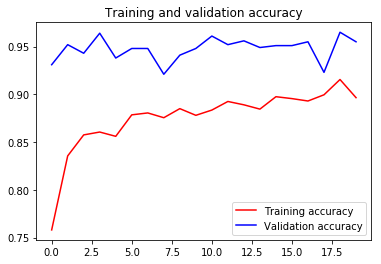

<Figure size 432x288 with 0 Axes>

In [10]:
# 將其結果印出觀察
# 有趣的是，如果你這樣做，那就是你有不同的情況。
# 以下是培訓與驗證準確性的圖表。正如您所看到的，雖然它開始很好，但驗證與培訓的分歧非常糟糕。所以，我們如何解決這個問題？下一篇
# Another useful tool to explore at this point is the Dropout.(丟掉部分，避免深度學習下稀釋及發散) 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()